In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as Rot
import scipy.optimize
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# %matplotlib notebook

from scipy.interpolate import interp2d, Rbf
from scipy.linalg import lstsq

In [3]:
#file reading function firstly, to be attached to class as method probably (create map from filename argument only)
def zygoread(filename):
    with open(filename, "r") as f:
        fstrings = f.read().split("\"")
        
        fields = []
        data = []
        section = 0
        for elt in fstrings:
            if "#" in elt:  # - use this test to show end of header section, then switch to next section
                section += 1
                pass
            
            if section == 0:  # - processing header section
                #multiple fields are stored within single strings, so need to split by newline to narrow down
                #numbers stored within strings can be extracted afterwards
                #excess artifacts can be filtered out using if (True) test on elements of split string
                #fails on empty string, thus keeping only the relevant fields
                elt = elt.split("\n")
                values = [_ for _ in elt if _]  # - filter bad elements (e.g. "" which have no data and return False)
                #test for non-empty lists (indicates no data was found in values list)
                if values:
                    fields.append(values)
            
            elif section == 1:  # - move to data extraction for intensities and phases
                #the initial split left the both datasets in a single string - separate by "#"
                #split string containing a dataset then iterate through the resulting lines of 10
                #append all values to a 'data' array, filter as before
                #splitting by "#" will result in 2 list stored in the 'data' list
                #i.e. can extract: intensities = data[0], phases = data[1]
                for line in elt.split("#"):
                    values = [_ for _ in line.split() if _]
                    if values:
                        data.append(values)
                
        
        
        
    return fields, data

In [4]:
class zygomap:
    
    def crop(self, radius=0):
        #allow user to crop to extract only data within some radius
        #most needed to avoid large edge effects (discontinuities)
        #use the (stored) centred x and y positions to check against radius
        #make a new cropped array where points outwith radius are set to nan
        #and "zoom in" to store only the array within the valid range
        #will run during __init__(), with default radius = 0, so can avoid editing if radius is default
        #and only do if user chose a (non-zero) radius
        #thus only the centring of view by array slicing is performed (no need for separate functions)
        
        #set cropped array based on original state of heights (so not cropping multiple times and losing data)
        cropped = self.heights0.copy()
        
        if radius != 0:
            #if radius non-zero, we will be setting valid points to invalid (nan)
            #use centred x,y grid points for full data array to make a mask for points outside radius
            outsideR = self.x**2 + self.y**2 > radius**2
            cropped[outsideR] = np.nan
            
            #could add a flag/callback here to automatically re-apply rotations after crops (otherwise advise user to do it)
            #e.g. if callback = True -> rotateflat()
        
        #now find the extreme bounds of valid points and slice the array to show only the data within
        validrows, validcols = np.where(np.isfinite(cropped))
        lft, rgt, upp, low = np.nanmin(validcols), np.nanmax(validcols), np.nanmin(validrows), np.nanmax(validrows)
        
        cropped = cropped[upp:low+1, lft:rgt+1]
        self.heights = cropped.copy()
        
        return cropped
    
    def testf(self, *args):
        angx, angy = args[0]  # - format of scipy minimize requires a single 1st argument to alter - can have list with multiple
        array = args[1]  # - the simple 2D array of height values

        dims = array.shape
        x,y = np.indices(dims)
        
        #make array of position vectors in Nx3 format: i.e. [x,y,height] as a single element for one point in 3D
        #use dstack to arrange the separate array values down each column, then reshape to Nx3 array
        vectarray = np.dstack([x,y,array])
        vectarray = vectarray.reshape(int(vectarray.size/3), 3)

        #define rotations around x and y axes respectively and combine via * operation
        rx = Rot.from_rotvec(angx*np.array([1,0,0]))
        ry = Rot.from_rotvec(angy*np.array([0,1,0]))
        r = rx*ry

        #apply overall rotation to entire vector array (rotates each vector individually)
        #extract back individual columns and store them in original array dimensions
        newarray = r.apply(vectarray)
        newheights = newarray[:,2].reshape(dims)

        #check the peak to valley height of rotated array
        peakvalley = np.nanmax(newheights) - np.nanmin(newheights)    

        return peakvalley
    
    def rotateflat(self, array):
        #apply minimization
        #call to external testf() (or make testf internal ?)
        #then apply best rotation and return rotated array
        #"array" argument left so normal or cropped maps can be used (i.e. self.heights vs self.cropped)
        
        #minimise peak to valley height for rotation angles around x-axis and y-axis
        opts = {"ftol":1e-15, "xtol":1e-15, "maxiter":1000}
        params = scipy.optimize.minimize(self.testf, x0=[0,0], args=array, tol=1e-15, method="Nelder-Mead", options=opts)
        angx,angy = params["x"]  # - access the optimal angles found by the minimisation
        
        
        #now apply the optimal rotations (same method as contained in test function, "testf")
        dims = array.shape
        x,y = np.indices(dims)
        
        vectarray = np.dstack([x,y,array])
        vectarray = vectarray.reshape(int(vectarray.size/3), 3)
        
        rotx = Rot.from_rotvec(angx*np.array([1,0,0]))
        roty = Rot.from_rotvec(angy*np.array([0,1,0]))
        r = rotx*roty
        
        newarray = r.apply(vectarray)
        newheights = newarray[:,2].reshape(dims)
        
        #centre in z-axis
        newheights -= np.nanmean(newheights)
        
        self.peak, self.valley = np.nanmax(newheights), np.nanmin(newheights)
        self.peakvalley = self.peak - self.valley
        self.rmsHeight = np.sqrt(np.nanmean(newheights**2))
        
        #update the stored heights array
        self.heights = newheights.copy()
        
        return newheights
    
    
    def __init__(self, filename=None, array=None):
        if filename is not None:
            #get header and data from file by user-defined function "zygoread" (change to class method ?)
            fields, data = zygoread(filename)

            #header extraction
            self.stringConstant = fields[0][0]
            chunk = fields[0][1].split()
            self.softwareType, self.majorVersion, self.minorVersion, self.bugVers = [int(n) for n in chunk]

            self.softwareDate = fields[1][0]

            chunk = fields[2][0].split()
            self.intensOriginX, self.intensOriginY, self.intensWidth, self.intensHeight, self.Nbuckets, self.intensRange = [int(n) for n in chunk]

            chunk = fields[2][1].split()
            self.phaseOriginX, self.phaseOriginY, self.phaseWidth, self.phaseHeight = [int(n) for n in chunk]

            self.comment = fields[3][0]

            self.partSerNum = fields[4][0]
            self.partNum = fields[5][0]

            chunk = fields[6][0].split()
            self.source = int(chunk.pop(0))
            self.timeStamp = int(chunk.pop(-1))
            self.intfScaleFactor, self.wavelengthIn, self.numericAperture, self.obliquityFactor, self.magnification, self.cameraRes = [float(n) for n in chunk]

            chunk = fields[6][1].split()
            self.cameraWidth, self.cameraHeight, self.systemType, self.systemBoard, self.systemSerial, self.instrumentId = [int(n) for n in chunk]

            self.objectiveName = fields[7][0]

            #want both index 6 & 7 seperately, as they need to be floats
            #convert the rest to int as before
            chunk = fields[8][0].split()  # - looks messier but should use this throughout to reduce repeated splitting
            self.targetRange = float(chunk.pop(6))  # - remove item at index 6 and returns it (and modifies original list)
            self.lightLevel = float(chunk.pop(6))  # - do it again as the index 7 is now at index 6 in the modified list
            self.acquireMode, self.intensAvgs, self.PZTCal, self.PZTGain, self.PZTGainTolerance, self.AGC, self.minMod, self.minModPts = [int(n) for n in chunk]

            chunk = fields[8][1].split()
            self.disconFilter = float(chunk.pop(4))
            self.phaseRes, self.phaseAvgs, self.minimumAreaSize, self.disconAction, self.connectionOrder, self.removeTiltBias, self.dataSign, self.codeVType = [int(n) for n in chunk]

            self.subtractSysErr = int(fields[8][2])

            self.sysErrFile = fields[9][0]

            chunk = fields[10][0].split()
            self.refractiveIndex, self.partThickness = [float(n) for n in chunk]

            self.zoomDesc = fields[11][0]


            #extract intensity and phase data as numpy arrays (reshape to header parameters)
            self.intensitymap = np.array(data[0], dtype=float).reshape(self.intensHeight, self.intensWidth)
            self.phasemap = np.array(data[1], dtype=float).reshape(self.phaseHeight, self.phaseWidth)

            #handle invalid values (given in MetroPro manual)
            self.intensitymap[self.intensitymap >= 64512] = np.nan
            self.phasemap[self.phasemap >= 2147483640] = np.nan

            #create arrays in terms of number of waves, and height itself
            #by given formula
            if self.phaseRes == 0:
                self.R = 4096
            elif self.phaseRes == 1:
                self.R = 32768
            self.waves = self.phasemap*(self.intfScaleFactor*self.obliquityFactor)/self.R
            self.heights = self.waves*self.wavelengthIn
             
        elif array is not None:
            #allow map object to be created from scratch (i.e. make interface as a map object directly)
            self.heights = array.copy()
        
        ########################
        ########################
        ##pre-processing maps
        
        #grid points for use in some methods (just using array i,j position index (can scale later))
        self.y, self.x = np.indices(self.heights.shape)
        
        #apply cropping first (user-defined radius ? or default ?)
        #self.cropped = self.crop(self.heights)
        #orderings/logistics of this needs fixed: which array is edited? when? what effect should user cropping give?
        #create a copy of the initial height array, this allows crop to act on those values and provide new self.heights
        #without data loss
        self.heights0 = self.heights.copy()
#         self.cropped = self.heights[:]  # - slice notation actually still links the variables, need np.copy() instead
        
        #adjust to centre of valid points (centre of surface)
        self.validrows, self.validcols = np.where(np.isfinite(self.heights0))
        self.centre = int(np.nanmean(self.validrows)), int(np.nanmean(self.validcols))
        self.x -= self.centre[1]
        self.y -= self.centre[0]
        
        self.crop()
        
        #remove tilt if present
        self.heights = self.rotateflat(self.heights)
        
        
        #moved below into rotateflat(), so they are automatically recalculated
        #storing: self.peak, self.valley, self.peakvalley, self.rmsHeight
        #based on the rotated map (i.e. not stored unless rotation removed (would be inaccurate but could do for completeness))
        # - could make a separate function, to be performed at any time but is there any point ?
        #centring in z-axis
#         self.heights -= np.nanmean(self.heights)
        
        #end calculations
#         self.peakvalley = np.nanmax(self.heights) - np.nanmin(self.heights)
        
        return

In [5]:
map1 = zygomap("M1.txt")
map2 = zygomap("M2.txt")

#### using linear plane fit to compare tilts

In [6]:
map1.crop()  # - reset view
arr = map1.heights.copy()
arr.shape

(71, 70)

In [8]:
x,y = np.indices(arr.shape)

f = interp2d(x.flatten(),y.flatten(), arr, kind="linear")

In [11]:
f.__dict__

{'tck': [array([ 0.,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, 70., 70.]),
  array([ 0.,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, 69., 69.]),
  array([nan, nan, nan, ..., nan, nan, nan]),
  1,
  1],
 'bounds_error': False,
 'fill_value': None,
 'x': array([ 0,  0,  0, ..., 70, 70, 70]),
 'y':

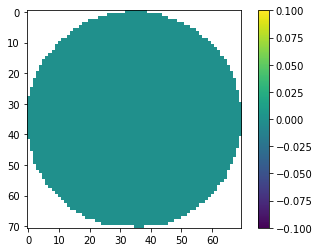

In [12]:
plt.imshow((map1.heights - f.z.reshape(arr.shape))**2)
plt.colorbar()
plt.show()

In [13]:
np.nanmax(f.z) - np.nanmin(f.z)

1.4147525512695313e-06

In [9]:
#example of using scipy.linalg.lstq (here with random 3D data)
#find coefficients for flat plane to fit data and reconstruct over the grid points x & y

mean = np.array([0.0,0.0,0.0])
cov = np.array([[1.0,-0.5,0.8], [-0.5,1.1,0.0], [0.8,0.0,1.0]])
data = np.random.multivariate_normal(mean, cov, 50)

A = np.dstack((data[:,0], data[:,1], np.ones(data.shape[0])))
coefficients,res,rank,sing = lstsq(A[0], data[:,2])

Z = coefficients[0]*x + coefficients[1]*y + coefficients[2]

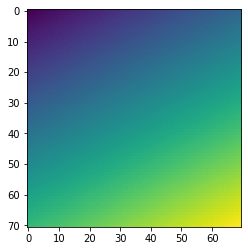

In [10]:
plt.imshow(Z)
plt.show()

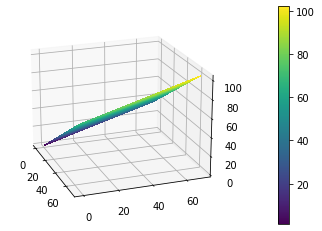

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
# ax.set_zlim(map1.valley, map1.peak)

# x,y = np.indices(interfacemap.heights.shape)
x,y = f.x.reshape(arr.shape), f.y.reshape(arr.shape)
bestfit = f.z.reshape(arr.shape)

current_cmap = copy.copy(cm.get_cmap("viridis"))
p = ax.plot_surface(x,y, Z, antialiased=False, cmap=current_cmap)
# p = ax.plot_surface(x,y, bestfit, antialiased=False, cmap=current_cmap)
# p.cmap.set_bad("black", alpha=1)

plt.colorbar(p, pad=0.16)

ax.view_init(elev=20, azim=-20)

plt.show()